# 🌈 Gaussian Naïve Bayes from Scratch
A concise walk-through of the probabilistic assumptions, maths and pure-NumPy implementation of the Gaussian Naïve Bayes classifier.

## 🔍 What is Naïve Bayes?
- **Generative** probabilistic classifier.  
- Applies **Bayes’ theorem** with the *naïve* assumption:  
  **features are conditionally independent given the class**.  
- For continuous data we assume a **Gaussian class-conditional density**.  
- No iterative optimisation; parameters are **closed-form** via MLE.

## 🧮 Bayes’ Rule
For a query sample $\mathbf{x}$ and class $c_k$:

$$
P(c_k \mid \mathbf{x}) \propto P(c_k) \prod_{i=1}^{d} P(x_i \mid c_k)
$$

**Prediction**: pick the class with the **highest posterior probability**:

$$
\hat{y} = \arg\max_{c_k} P(c_k) \prod_{i=1}^{d} P(x_i \mid c_k)
$$

Numerical stability trick: compute everything in **log-space**:

$$
\hat{y} = \arg\max_{c_k} \Big[ \log P(c_k) + \sum_{i=1}^{d} \log P(x_i \mid c_k) \Big]
$$

## 🔔 Gaussian Class-Conditional PDF
For feature $x_i$ given class $c_k$:

$$
P(x_i \mid c_k) = \frac{1}{\sqrt{2\pi\sigma_{ki}^2}} \exp\!\left(-\frac{(x_i - \mu_{ki})^2}{2\sigma_{ki}^2}\right)
$$

Parameters are **maximum-likelihood estimates**:

$$
\mu_{ki} = \frac{1}{|D_k|} \sum_{\mathbf{x} \in D_k} x_i, \quad
\sigma_{ki}^2 = \frac{1}{|D_k|} \sum_{\mathbf{x} \in D_k} (x_i - \mu_{ki})^2
$$

Prior probabilities:

$$
P(c_k) = \frac{|D_k|}{m}
$$

In [1]:
import numpy as np

class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # MLE parameters for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var  = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :]  = X_c.var(axis=0)
            self._priors[idx]  = X_c.shape[0] / n_samples

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posteriors.append(prior + class_conditional)
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var  = self._var[class_idx]
        numerator   = np.exp(-0.5 * ((x - mean) ** 2) / var)
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

## 🧪 Dataset – Synthetic Binary Classification
`make_classification` gives us 1 000 samples, 10 features, 2 classes.

In [2]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples=1000, n_features=10,
                                    n_classes=2, random_state=123)
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")

Samples: 1000, Features: 10


## ✂️ Train / Test Split
Hold-out 20 % for unbiased evaluation.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y)

## 🎯 Training
Closed-form estimates of μ, σ² and priors – no gradient descent needed!

In [4]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

## 📏 Evaluation – Accuracy
Standard classification accuracy:

$$
\text{Accuracy} = \frac{1}{m}\sum_{i=1}^{m}\mathbb{1}[\hat{y}_i = y_i]
$$

In [5]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

y_pred = nb.predict(X_test)
acc = accuracy(y_test, y_pred)
print(f"Gaussian Naïve Bayes accuracy: {acc:.2%}")

Gaussian Naïve Bayes accuracy: 95.50%


## 🎨 Visualise One Feature’s Class Densities
Pick any single feature and plot the learned Gaussian for each class.

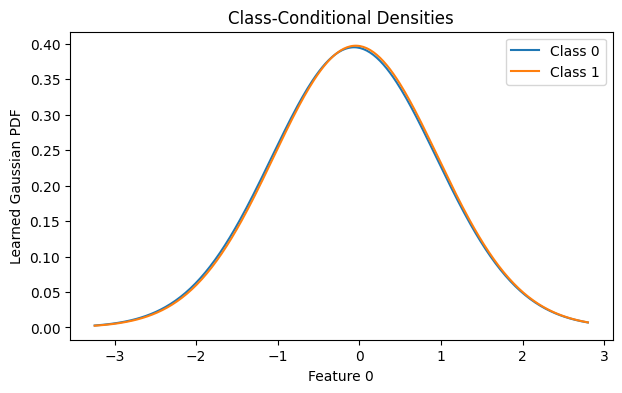

In [6]:
import matplotlib.pyplot as plt

feat_idx = 0
mean0, var0 = nb._mean[0, feat_idx], nb._var[0, feat_idx]
mean1, var1 = nb._mean[1, feat_idx], nb._var[1, feat_idx]

x_range = np.linspace(X_train[:, feat_idx].min(), X_train[:, feat_idx].max(), 300)
pdf0 = (1/np.sqrt(2*np.pi*var0)) * np.exp(-0.5*(x_range-mean0)**2 / var0)
pdf1 = (1/np.sqrt(2*np.pi*var1)) * np.exp(-0.5*(x_range-mean1)**2 / var1)

plt.figure(figsize=(7,4))
plt.plot(x_range, pdf0, label="Class 0")
plt.plot(x_range, pdf1, label="Class 1")
plt.xlabel(f"Feature {feat_idx}")
plt.ylabel("Learned Gaussian PDF")
plt.title("Class-Conditional Densities")
plt.legend()
plt.show()

## ✅ Summary – Equations Recap
- **Bayes’ rule**: $P(c_k \mid \mathbf{x}) \propto P(c_k)\prod_i P(x_i \mid c_k)$  
- **Gaussian PDF**: $\mathcal{N}(x_i; \mu_{ki}, \sigma_{ki}^2)$  
- **Log-posterior**: $\log P(c_k) + \sum_i \log P(x_i \mid c_k)$  
- **Prediction**: $\hat{y} = \arg\max_{c_k} \text{log-posterior}$  
- **Training**: closed-form MLE estimates – **no iterative optimisation**

Feel free to experiment: try **Laplace smoothing**, **multinomial** or **Bernoulli** variants, or **kernel density** instead of the Gaussian assumption!